c:\Users\Lab419_6\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


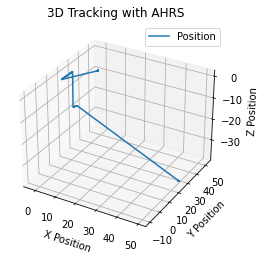

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

class AHRS:
    def __init__(self):
        self.quaternion = np.array([1, 0, 0, 0])
    def update_imu(self, gyroscope, accelerometer):
        pass  # 자세 업데이트 로직 구현 필요

class KalmanAngle:
    def __init__(self, Q_angle=0.001, Q_bias=0.003, R_measure=0.03):
        self.Q_angle = Q_angle
        self.Q_bias = Q_bias
        self.R_measure = R_measure
        self.angle = 0.0
        self.bias = 0.0
        self.rate = 0.0
        self.P = np.zeros((2, 2))

    def getAngle(self, newAngle, newRate, dt):
        self.rate = newRate - self.bias
        self.angle += dt * self.rate
        self.P[0][0] += dt * (dt*self.P[1][1] - self.P[0][1] - self.P[1][0] + self.Q_angle)
        self.P[0][1] -= dt * self.P[1][1]
        self.P[1][0] -= dt * self.P[1][1]
        self.P[1][1] += self.Q_bias * dt
        y = newAngle - self.angle
        S = self.P[0][0] + self.R_measure
        K = [self.P[0][0] / S, self.P[1][0] / S]
        self.angle += K[0] * y
        self.bias += K[1] * y
        self.P[0][0] -= K[0] * self.P[0][0]
        self.P[0][1] -= K[0] * self.P[0][1]
        self.P[1][0] -= K[1] * self.P[0][0]
        self.P[1][1] -= K[1] * self.P[0][1]
        return self.angle

def calculate_angles(accelerometer, gyroscope):
    acc_x, acc_y, acc_z = accelerometer
    gyro_x, gyro_y, gyro_z = gyroscope
    roll = np.arctan2(acc_y, acc_z)
    pitch = np.arctan2(-acc_x, np.sqrt(acc_y**2 + acc_z**2))
    yaw = 0  # 자이로스코프 데이터를 사용하여 Yaw 계산 필요
    return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

# 데이터 로드 및 처리
df = pd.read_csv('C:/Users/Lab419_6/Desktop/20192230 이동섭/IMU sensor/test/time, accl, gyro, magn, angl, vel, pos.csv')
positions = df[['Pos_X', 'Pos_Y', 'Pos_Z']]
kalman_filter_x = KalmanAngle()
kalman_filter_y = KalmanAngle()
kalman_filter_z = KalmanAngle()
estimated_angles = []

# 데이터 처리 및 시각화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for index, row in df.iterrows():
    accelerometer = [row['Accl_X'], row['Accl_Y'], row['Accl_Z']]
    gyroscope = [row['Gyro_X'], row['Gyro_Y'], row['Gyro_Z']]
    angle_x, angle_y, angle_z = calculate_angles(accelerometer, gyroscope)
    estimated_x = kalman_filter_x.getAngle(angle_x, gyroscope[0], 1/256)
    estimated_y = kalman_filter_y.getAngle(angle_y, gyroscope[1], 1/256)
    estimated_z = kalman_filter_z.getAngle(angle_z, gyroscope[2], 1/256)
    q = R.from_euler('xyz', [estimated_x, estimated_y, estimated_z]).as_quat()
    position = [row['Pos_X'], row['Pos_Y'], row['Pos_Z']]
    rot = R.from_quat(q)
    vectors = rot.apply(np.eye(3))
    ax.quiver(position[0], position[1], position[2], vectors[0, 0], vectors[1, 0], vectors[2, 0], length=0.1, normalize=True)

ax.plot(positions['Pos_X'], positions['Pos_Y'], positions['Pos_Z'], label='Position')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
plt.title('3D Tracking with AHRS')
plt.legend()
plt.show()